# Case study of the december 6 2021 storm melting layer in altitude


---

**Author**: Olivier Chalifour
**Organisation**: UQAM
**Date**: 26 July 2021

---

In [1]:
"""
Import
"""
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import os
import glob
import sys
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error
import scipy.stats
import math
import time as time_mod
import xarray as xr
sys.path.insert(0, "/home/chalifour/code/master")
import fct_script.rpn_funcs_chris as rpn_chris
import metpy.calc as mpcalc
import metpy.interpolate as metinterp
from metpy.plots import SkewT
from metpy.units import units
from tqdm.notebook import trange, tqdm
# from func_py import get_proj_extent

try:
    import rpnpy.librmn.all as rmn  # Module to read RPN files
    from rotated_lat_lon import RotatedLatLon  # Module to project field on native grid (created by Sasha Huziy)
except ImportError as err:
    print(f"RPNPY can only be use on the server. It can't be use on a personal computer."
          f"\nError throw :{err}")

In [2]:

# date = '2022-03-06 00'
# f_hr = 48
# # date = '2021-12-05 00'
# # f_hr = 72
#
# datetimeobject = datetime.strptime(date, '%Y-%m-%d %H')
# new_format = datetimeobject.strftime('%Y%m%d')
# format_rpn_file = datetimeobject.strftime('%Y%m')
#
# run = pd.Timestamp(fr'{date}')
#
#
# valid_time = run + pd.Timedelta(str(f_hr) + ' h')
# timestamps = pd.date_range(run, valid_time, freq='12 H')
# time = timestamps
# timestamps_h = pd.date_range(run, valid_time, freq='1 H')
# time_h = timestamps_h
# start = run
# end = valid_time
# begin, end = '2021-04', '2021-06'
begin, end = '2020-10', '2021-05'
begin_date, end_date = datetime.strptime(begin, '%Y-%m'), datetime.strptime(end, '%Y-%m')

timerange_month = pd.date_range(begin, end, freq='MS')

timerange_day = pd.date_range(begin, end, freq='D')
timerange_12h = pd.date_range(begin, end, freq='12h')[:-1]


In [3]:
# Simulation Data path

# path_dict_sim_11km = fr'/chinook/roberge/Output/GEM5/Olivier/NAM-11m_ERA5_GEM50_PCPTYPEnil'
# file_name_20211_11km = f'Samples/NAM-11m_ERA5_GEM50_PCPTYPEnil_{format_rpn_file}'
# path_202112_11km = [os.path.join(path_dict_sim_11km, file_name_20211_11km)]
#
# path_dict_sim_2p5km = '/chinook/roberge/Output/GEM5/Olivier/ECan_2.5km_NAM11mP3_GEM50_PCPTYPEnil'
# file_name_20211_2p5km = f'Samples/ECan_2.5km_NAM11mP3_GEM50_PCPTYPEnil_{format_rpn_file}'
# path_202112_2p5km = [os.path.join(path_dict_sim_2p5km, file_name_20211_2p5km)]

path_sim_11km_1 = glob.glob("/chinook/roberge/Output/GEM5/Olivier/NAM-11m_ERA5_GEM50_PCPTYPEnil/Samples/NAM-11m_ERA5_GEM50_PCPTYPEnil_20220*[0-5]")

path_sim_11km_2 = glob.glob("/chinook/roberge/Output/GEM5/Olivier/NAM-11m_ERA5_GEM50_PCPTYPEnil/Samples/NAM-11m_ERA5_GEM50_PCPTYPEnil_20211*[0-2]")
path_sim_11km = sorted(path_sim_11km_1+path_sim_11km_2)

path_sim_2p5_1 = glob.glob("/chinook/roberge/Output/GEM5/Olivier/ECan_2.5km_NAM11mP3_GEM50_PCPTYPEnil/Samples/ECan_2.5km_NAM11mP3_GEM50_PCPTYPEnil_20220*[0-5]")
path_sim_2p5_2 = glob.glob("/chinook/roberge/Output/GEM5/Olivier/ECan_2.5km_NAM11mP3_GEM50_PCPTYPEnil/Samples/ECan_2.5km_NAM11mP3_GEM50_PCPTYPEnil_20211*[0-2]")
path_sim_2p5km = sorted(path_sim_2p5_1+path_sim_2p5_2)


path_data_saving = f"/upslope/chalifour/projet_maitrise/data_sim_station/sounding"

# image output dir
image_output_dir = "/upslope/chalifour/projet_maitrise/fig/case_analysis"

# Important information
image_output_dpi = 200

# lat,lon station à étudier
# station radiosondage
# maniwaki,sept-ile,
name_stat = ['WMW','YZV']
lat_sond = [46.3019, 50.2233]
lon_sond = [-76.0061, -66.2656]


# Get data altitude for each simulation

- P3
- Temp en altitude

In [4]:
# Data P3 constant
pressure_level = [1000.,975.,950.,925.,900.,850.,800.,700.,600.,500.,400.,300.,250.,200.,150.,100.]
ip1_list=[]
for pres in pressure_level:
    ip1_pres = rmn.ip1_val(pres, rmn.LEVEL_KIND_PMB)
    ip1_list.append(ip1_pres)
# variable: rain masse mixing ration, ice masse mixing ration, rime masse mixing ration, total equivalent reflectivity
# variable_alt = ["TT",'HU']
variable_alt = ['GZ']
var_name=["Temperature [\u2103]","Rain mass mixing ratio [kg/kg]","Total mass mixing ratio for ice category 1 [kg/kg]","Rime mass mixing ratio for ice category 1[kg/kg]"]


In [ ]:

for reso, path_alt in zip(["11km","2p5km"],[path_sim_11km ,path_sim_2p5km]):
    print(f'Getting {reso} simualtion')
    dict_idx_nearest_pt = {}
    for v,name in enumerate(name_stat):
            dict_idx_nearest_pt[name] = {}
    # df_sim_stat = pd.DataFrame()
    # dict_gen = {'time':[],'filename':[]}
    # for phase in variable_alt:
    #     dict_gen[phase]=[]



    for idx in range(len(timerange_month.month)-1):
        # print(f'Getting {timerange_month[idx].year}-{timerange_month[idx].month} ')

        timerange_hour = pd.date_range(timerange_month[idx].strftime('%Y-%m'),timerange_month[idx+1].strftime('%Y-%m'),freq='12h')

        timerange_hour = timerange_hour[timerange_hour.month == timerange_month[idx].month]

        timerange_hour_datev = []

        for date_h in timerange_hour:
            timerange_hour_datev.append(rpn_chris.date_to_datev(date_h))

        try:
            rmn.fstcloseall(fid_2)
        except:
            pass

        dict_stat = {}
        for v,name in enumerate(name_stat):
            dict_stat[name] = {}
            for j,phase in enumerate(variable_alt):
                df = pd.DataFrame(columns=pressure_level,index=timerange_hour)
                dict_stat[name][phase] = df

        fid_2 = rmn.fstopenall(path_alt[idx]+'/dp*',rmn.FST_RO)
        with tqdm(total=len(timerange_hour)*len(variable_alt)*len(ip1_list)*len(name_stat)) as pbar:
            pbar.set_description(f'Processing {timerange_month[idx].year}-{timerange_month[idx].month}')
            for hidx,datev in enumerate(timerange_hour_datev):

                for j,phase in enumerate(variable_alt):
                    # pbar.set_description(f'Processing {timerange_month[idx].year}-{timerange_month[idx].month} {phase}')

                    for ip1i,ip1_val in enumerate(ip1_list):

                            try:
                                key1 = rmn.fstinf(fid_2, nomvar=phase)
                                rec = rmn.fstlirx(key1, fid_2, nomvar=phase, datev=datev,ip1=ip1_val)

                                mygrid = rmn.readGrid(fid_2,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
                                latlondict = rmn.gdll(mygrid)
                                lat_var = latlondict['lat']                     # Assign 'lat' to 2-D latitude field
                                lon_var = latlondict['lon']

                                for v,name in enumerate(name_stat):
                                    # pbar.set_description(f'Processing {timerange_month[idx].year}-{timerange_month[idx].month} {phase} {name}')
                                    if len(dict_idx_nearest_pt[name]) == 0:

                                        pyt = (lon_var-(360+lon_sond[v]))**2+(lat_var-lat_sond[v])**2

                                        idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
                                        dict_idx_nearest_pt[name] = [idx_lat,idx_lon]

                                        var_pt = [rec['d'][idx_lat,idx_lon]]
                                    else:
                                        idx_lat,idx_lon = dict_idx_nearest_pt[name]
                                        var_pt=[rec['d'][idx_lat,idx_lon]]

                                    dict_stat[name][phase].loc[timerange_hour[hidx],pressure_level[ip1i]] = var_pt[0]
                                    pbar.update(1)
                                    # print(dict_stat[name][phase])
                            except:
                                for v,name in enumerate(name_stat):
                                    dict_stat[name][phase].loc[timerange_hour[hidx],pressure_level[ip1i]] = np.nan
                                    pbar.update(1)




            rmn.fstcloseall(fid_2)
            for v,name in enumerate(name_stat):
                for j,phase in enumerate(variable_alt):
                    dict_stat[name][phase].to_csv(f'/upslope/chalifour/projet_maitrise/data_sim_station/sounding/{reso}/{phase}_{name}_{timerange_month[idx].year}{timerange_month[idx].month}.csv')
    # df_sim_stat = pd.DataFrame.from_dict(dict_gen)
    #
    # df_sim_stat.set_index('time',inplace=True)
    # df_sim_stat.sort_values(['filename','time'],inplace=True)
    #
    # # df_sim_stat.to_csv(f'//upslope/chalifour/projet_maitrise/data_sim_station/dataset_UQAM_MOMO_sim_11km_{begin.strip("_")}_{end.strip("_")}_HR.csv')
    # df_sim_stat.to_csv(f'//upslope/chalifour/projet_maitrise/data_sim_station/closest_point/dataset_UQAM_MOMO_sim_2p5kmP3_{begin.strip("_")}_{end.strip("_")}_HR.csv')

Getting 11km simualtion


  0%|          | 0/1984 [00:00<?, ?it/s]

  0%|          | 0/1920 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-2bc248fe1786>", line 37, in <module>
    fid_2 = rmn.fstopenall(path_alt[idx]+'/dp*',rmn.FST_RO)
  File "/sca/compilers_and_tools/python/python-rpn-3/lib/rpnpy/librmn/fstd98.py", line 307, in fstopenall
    fstouv(funit, filemode)
  File "/sca/compilers_and_tools/python/python-rpn-3/lib/rpnpy/librmn/fstd98.py", line 1759, in fstouv
    istat = _rp.c_fstouv(iunit, _C_WCHAR2CHAR(filemode))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2054, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardI

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-2bc248fe1786>", line 37, in <module>
    fid_2 = rmn.fstopenall(path_alt[idx]+'/dp*',rmn.FST_RO)
  File "/sca/compilers_and_tools/python/python-rpn-3/lib/rpnpy/librmn/fstd98.py", line 307, in fstopenall
    fstouv(funit, filemode)
  File "/sca/compilers_and_tools/python/python-rpn-3/lib/rpnpy/librmn/fstd98.py", line 1759, in fstouv
    istat = _rp.c_fstouv(iunit, _C_WCHAR2CHAR(filemode))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2054, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardI

# Get data sounding

In [5]:

path_data_WMW=f"/upslope/chalifour/projet_maitrise/data_sim_station/sounding/obs/WMW"
path_data_YZV=f"/upslope/chalifour/projet_maitrise/data_sim_station/sounding/obs/YZV"

In [ ]:
with tqdm(total=len(timerange_12h)*2) as pbar:
    for num,path in zip([71722,71811],[path_data_WMW,path_data_YZV]):
        pbar.set_description(f'Processing {num}')
        for i,timestamp in enumerate(timerange_12h):
            try:
                rpn_chris.download_sounding_data(f'{num}',timestamp,path)
                pbar.update(1)
            except:
                pbar.update(1)



ERROR! Session/line number was not unique in database. History logging moved to new session 1623


  0%|          | 0/848 [00:00<?, ?it/s]

# Figure

In [5]:
begin_1, end_1 = '2020-10', '2021-05'
begin_date_1, end_date_1 = datetime.strptime(begin, '%Y-%m'), datetime.strptime(end, '%Y-%m')

timerange_month_1 = pd.date_range(begin, end, freq='MS')

begin_2, end_2 = '2021-10', '2022-05'
begin_date_2, end_date_2 = datetime.strptime(begin, '%Y-%m'), datetime.strptime(end, '%Y-%m')

timerange_month_2 = pd.date_range(begin, end, freq='MS')

timerange_month = timerange_month_1[:-1].append(timerange_month_2[:-1])
timerange_12h_1 = pd.date_range(begin_1, end_1, freq='12h')[:-1]
timerange_12h_2 = pd.date_range(begin_2, end_2, freq='12h')[:-1]
timerange_12h = timerange_12h_1.append(timerange_12h_2)


In [14]:
#
# 2021-11-23 -> 1 sounding
# 2021-02-16 -> plusieurs sounding

image_output_dpi = 200
list_alt_zeros_deg_11km = [[],[]]
list_alt_zeros_deg_2p5km = [[],[]]
list_alt_zeros_deg_obs = [[],[]]



with tqdm(total=len(timerange_12h)) as pbar:

    for j,timestamp in enumerate(timerange_12h):
        pbar.set_description(f'Processing {timestamp}')
        # print(timestamp)
        # fig = plt.figure(facecolor='white', figsize=(10 , 12 ))
        path_gen = '/upslope/chalifour/projet_maitrise/data_sim_station/sounding'
        # spec = fig.add_gridspec(ncols=1, nrows=2, )
        # list_ax_WMW = []
        # list_ax_YZV = []


        # ax0 = fig.add_subplot(spec[0,0])
        # list_ax_WMW.append(ax0)
        # ax1 = fig.add_subplot(spec[1,0])
        # list_ax_YZV.append(ax1)
        # list_axs = [ax0,ax1]
        # list_axs = [list_ax_WMW,list_ax_YZV]
        year=timestamp.strftime('%Y')
        month=timestamp.strftime('%m')
        day = timestamp.strftime("%d")
        hour = timestamp.strftime('%H')
        mean_diff_list = [0,0]

        for idx_stat,stat in enumerate(name_stat):
            num_stat = [71722,71811][idx_stat]

            path_TT_11km = f'{path_gen}/11km/TT_{stat}_{year}{int(month)}.csv'
            df_TT_11km = pd.read_csv(path_TT_11km,header=0,index_col=0, parse_dates=True)

            path_TT_2p5km = f'{path_gen}/2p5km/TT_{stat}_{year}{int(month)}.csv'
            df_TT_2p5km = pd.read_csv(path_TT_2p5km,header=0,index_col=0, parse_dates=True)

            path_GZ_11km = f'{path_gen}/11km/GZ_{stat}_{year}{int(month)}.csv'
            df_GZ_11km = pd.read_csv(path_GZ_11km,header=0,index_col=0, parse_dates=True)*10
            df_GZ_11km[ df_GZ_11km < 0 ] = np.nan

            path_GZ_2p5km = f'{path_gen}/2p5km/GZ_{stat}_{year}{int(month)}.csv'
            df_GZ_2p5km = pd.read_csv(path_GZ_2p5km,header=0,index_col=0, parse_dates=True)*10
            df_GZ_2p5km[ df_GZ_2p5km < 0 ] = np.nan

            df_TT_11km_t = df_TT_11km.loc[timestamp]
            df_TT_2p5km_t = df_TT_2p5km.loc[timestamp]


            alt_interp_11km = metinterp.interpolate_1d(0,df_TT_11km_t.values,df_GZ_11km.loc[timestamp].values)
            alt_interp_2p5km = metinterp.interpolate_1d(0,df_TT_2p5km_t.values,df_GZ_2p5km.loc[timestamp].values)
            # print('11km',alt_interp_11km)
            list_alt_zeros_deg_11km[idx_stat].append(alt_interp_11km[0])

            list_alt_zeros_deg_2p5km[idx_stat].append(alt_interp_2p5km[0])

            # path_HU_11km = f'{path_gen}/11km/HU_{stat}_{year}{int(month)}.csv'
            # df_HU_11km = pd.read_csv(path_HU_11km,header=0,index_col=0, parse_dates=True)
            # path_HU_2p5km = f'{path_gen}/2p5km/HU_{stat}_{year}{int(month)}.csv'
            # df_HU_2p5km = pd.read_csv(path_HU_2p5km,header=0,index_col=0, parse_dates=True)


            # mean_diff_list[idx_stat] = mean_diff.loc[timestamp]



            try:
                """ OBS """
                path_data_obs = f"{path_gen}/obs/{stat}"
                path_sounding = f'{path_gen}/obs/{stat}/{num_stat}.{year}{month}{day}{hour}.txt'
                df_obs = pd.read_csv(path_sounding, index_col=None, header=0, delim_whitespace=True)
                df_obs = df_obs.dropna(subset=('DRCT', 'DWPT', 'SKNT', 'THTA', 'THTE', 'THTV',), how='all').reset_index(drop=True)

                # get data for the plot
                p_obs = df_obs['PRES'].values
                T_obs = df_obs['TEMP'].values
                Td_obs = df_obs['DWPT'].values
                height_obs = df_obs['HGHT'].values

                """ SIM """
                # P_level = pressure_level * units.hPa

                alt_interp_obs = metinterp.interpolate_1d(0,T_obs,height_obs)
                # print('obs',alt_interp_obs,'\n')
                list_alt_zeros_deg_obs[idx_stat].append(alt_interp_obs[0])
                # TT_11km = df_TT_11km.loc[timestamp].values * units.degC
                # TT_2p5km = df_TT_2p5km.loc[timestamp].values * units.degC
                # list_TT = [TT_11km,TT_2p5km]

                # HU_11km = (df_HU_11km.loc[timestamp].values * 1000) * units('g/kg')
                # HU_2p5km = (df_HU_2p5km.loc[timestamp].values * 1000) * units('g/kg')

                # TD_11km = mpcalc.dewpoint_from_specific_humidity(P_level,TT_11km,HU_11km)
                # TD_2p5km = mpcalc.dewpoint_from_specific_humidity(P_level,TT_2p5km,HU_2p5km)

                # list_TD = [TD_11km,TD_2p5km]


                # print(stat,np.mean(TT_11km))
                # skew = SkewT(fig,subplot=list_axs[idx_stat],rotation=0,aspect='auto')
                # if ~np.isnan(np.mean(TT_11km)) | ~np.isnan(np.mean(TT_2p5km)):

                    # for i, sim in enumerate(['12 km','2.5 km']):
                    #     list_color= ['tab:blue','tab:green']

                        # skew.plot(pressure_level, list_TT[i], linewidth=2, c = list_color[i], label=sim)
                        # skew.plot(pressure_level, list_TD[i], linewidth=2, c = list_color[i], ls='--')

                    # skew.plot(p_obs, T_obs, c='tab:red', linewidth=2, label='Obs')
                    # skew.plot(p_obs, Td_obs, c='tab:red', linewidth=2, ls='--')
                    # skew.ax.set_ylim(bottom=1050,top=500)
                    # skew.ax.set_xlim(-40, 20)
                    # skew.ax.tick_params(axis='both', which='major', labelsize=14)
                    # if idx_stat == 0:
                        # skew.ax.set_title(f'{timestamp.strftime("%Y-%m-%d %H%M")}UTC', loc='center', fontsize=16)
                    # skew.ax.set_ylabel('Pressure [hPa]', fontsize=16)
                    # skew.ax.set_xlabel('Temperature [\u2103]', fontsize=16)
                    # skew.ax.legend(loc='upper right', fontsize=14,)




            except:
                list_alt_zeros_deg_obs[idx_stat].append(np.nan)

        pbar.update(1)
        # else:
        #     pass
            # plt.close(fig)

        # list_axs[0].annotate('Maniwaki\nWMW', xy=(-0.6,.5), xycoords="axes fraction",fontsize = 16,ha='center' )
        # list_axs[1].annotate('Sept-Iles\nYZV', xy=(-0.6,.5), xycoords="axes fraction",fontsize = 16,ha='center' )
        # fig.tight_layout()


        # plt.savefig(fr"/upslope/chalifour/projet_maitrise/fig/sounding/all_year/{year}{month}{day}{hour}.png", bbox_inches='tight')
        # plt.show()
        # plt.close(fig)




  0%|          | 0/848 [00:00<?, ?it/s]

/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/metpy/interpolate/one_dimension.py:157: RuntimeWarning: divide by zero encountered in true_divide
  var_interp = var[below] + (var[above] - var[below]) * ((x_array - xp[below])
/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolat

In [15]:
list_pr_11km = [[],[]]
list_pr_2p5km = [[],[]]
time_list = [[],[]]
path_gen = '/upslope/chalifour/projet_maitrise/data_sim_station/sounding'





for time in timerange_month:
    year=time.strftime('%Y')
    month=time.strftime('%m')
    for idx_stat,stat in enumerate(name_stat):
        path_PR_11km = f'{path_gen}/11km/PR_{stat}_{year}{int(month)}.csv'
        df_PR_11km = pd.read_csv(path_PR_11km,header=0,index_col=0, parse_dates=True).resample('12H').sum()

        list_pr_11km[idx_stat].extend(df_PR_11km['ground'].values)

        path_PR_2p5km = f'{path_gen}/2p5km/PR_{stat}_{year}{int(month)}.csv'
        df_PR_2p5km = pd.read_csv(path_PR_2p5km,header=0,index_col=0, parse_dates=True).resample('12H').sum()

        list_pr_2p5km[idx_stat].extend(df_PR_2p5km['ground'].values)
        # print(df_PR_2p5km.index)
        # time_list[idx_stat].extend(df_PR_2p5km.index)


 WMW
obs 1645.5830824423963
obs std 1118.7965297704907

12 km 1476.5262780401024
12 km std 1107.1148815562292

2.5 km 1569.1534087991731
2.5 km std 1153.9763965055647

 YZV
obs 1340.7618645524738
obs std 980.5928615968709

12 km 1235.287052445867
12 km std 957.5412043195968

2.5 km 1294.0823577080407
2.5 km std 950.8216797706925


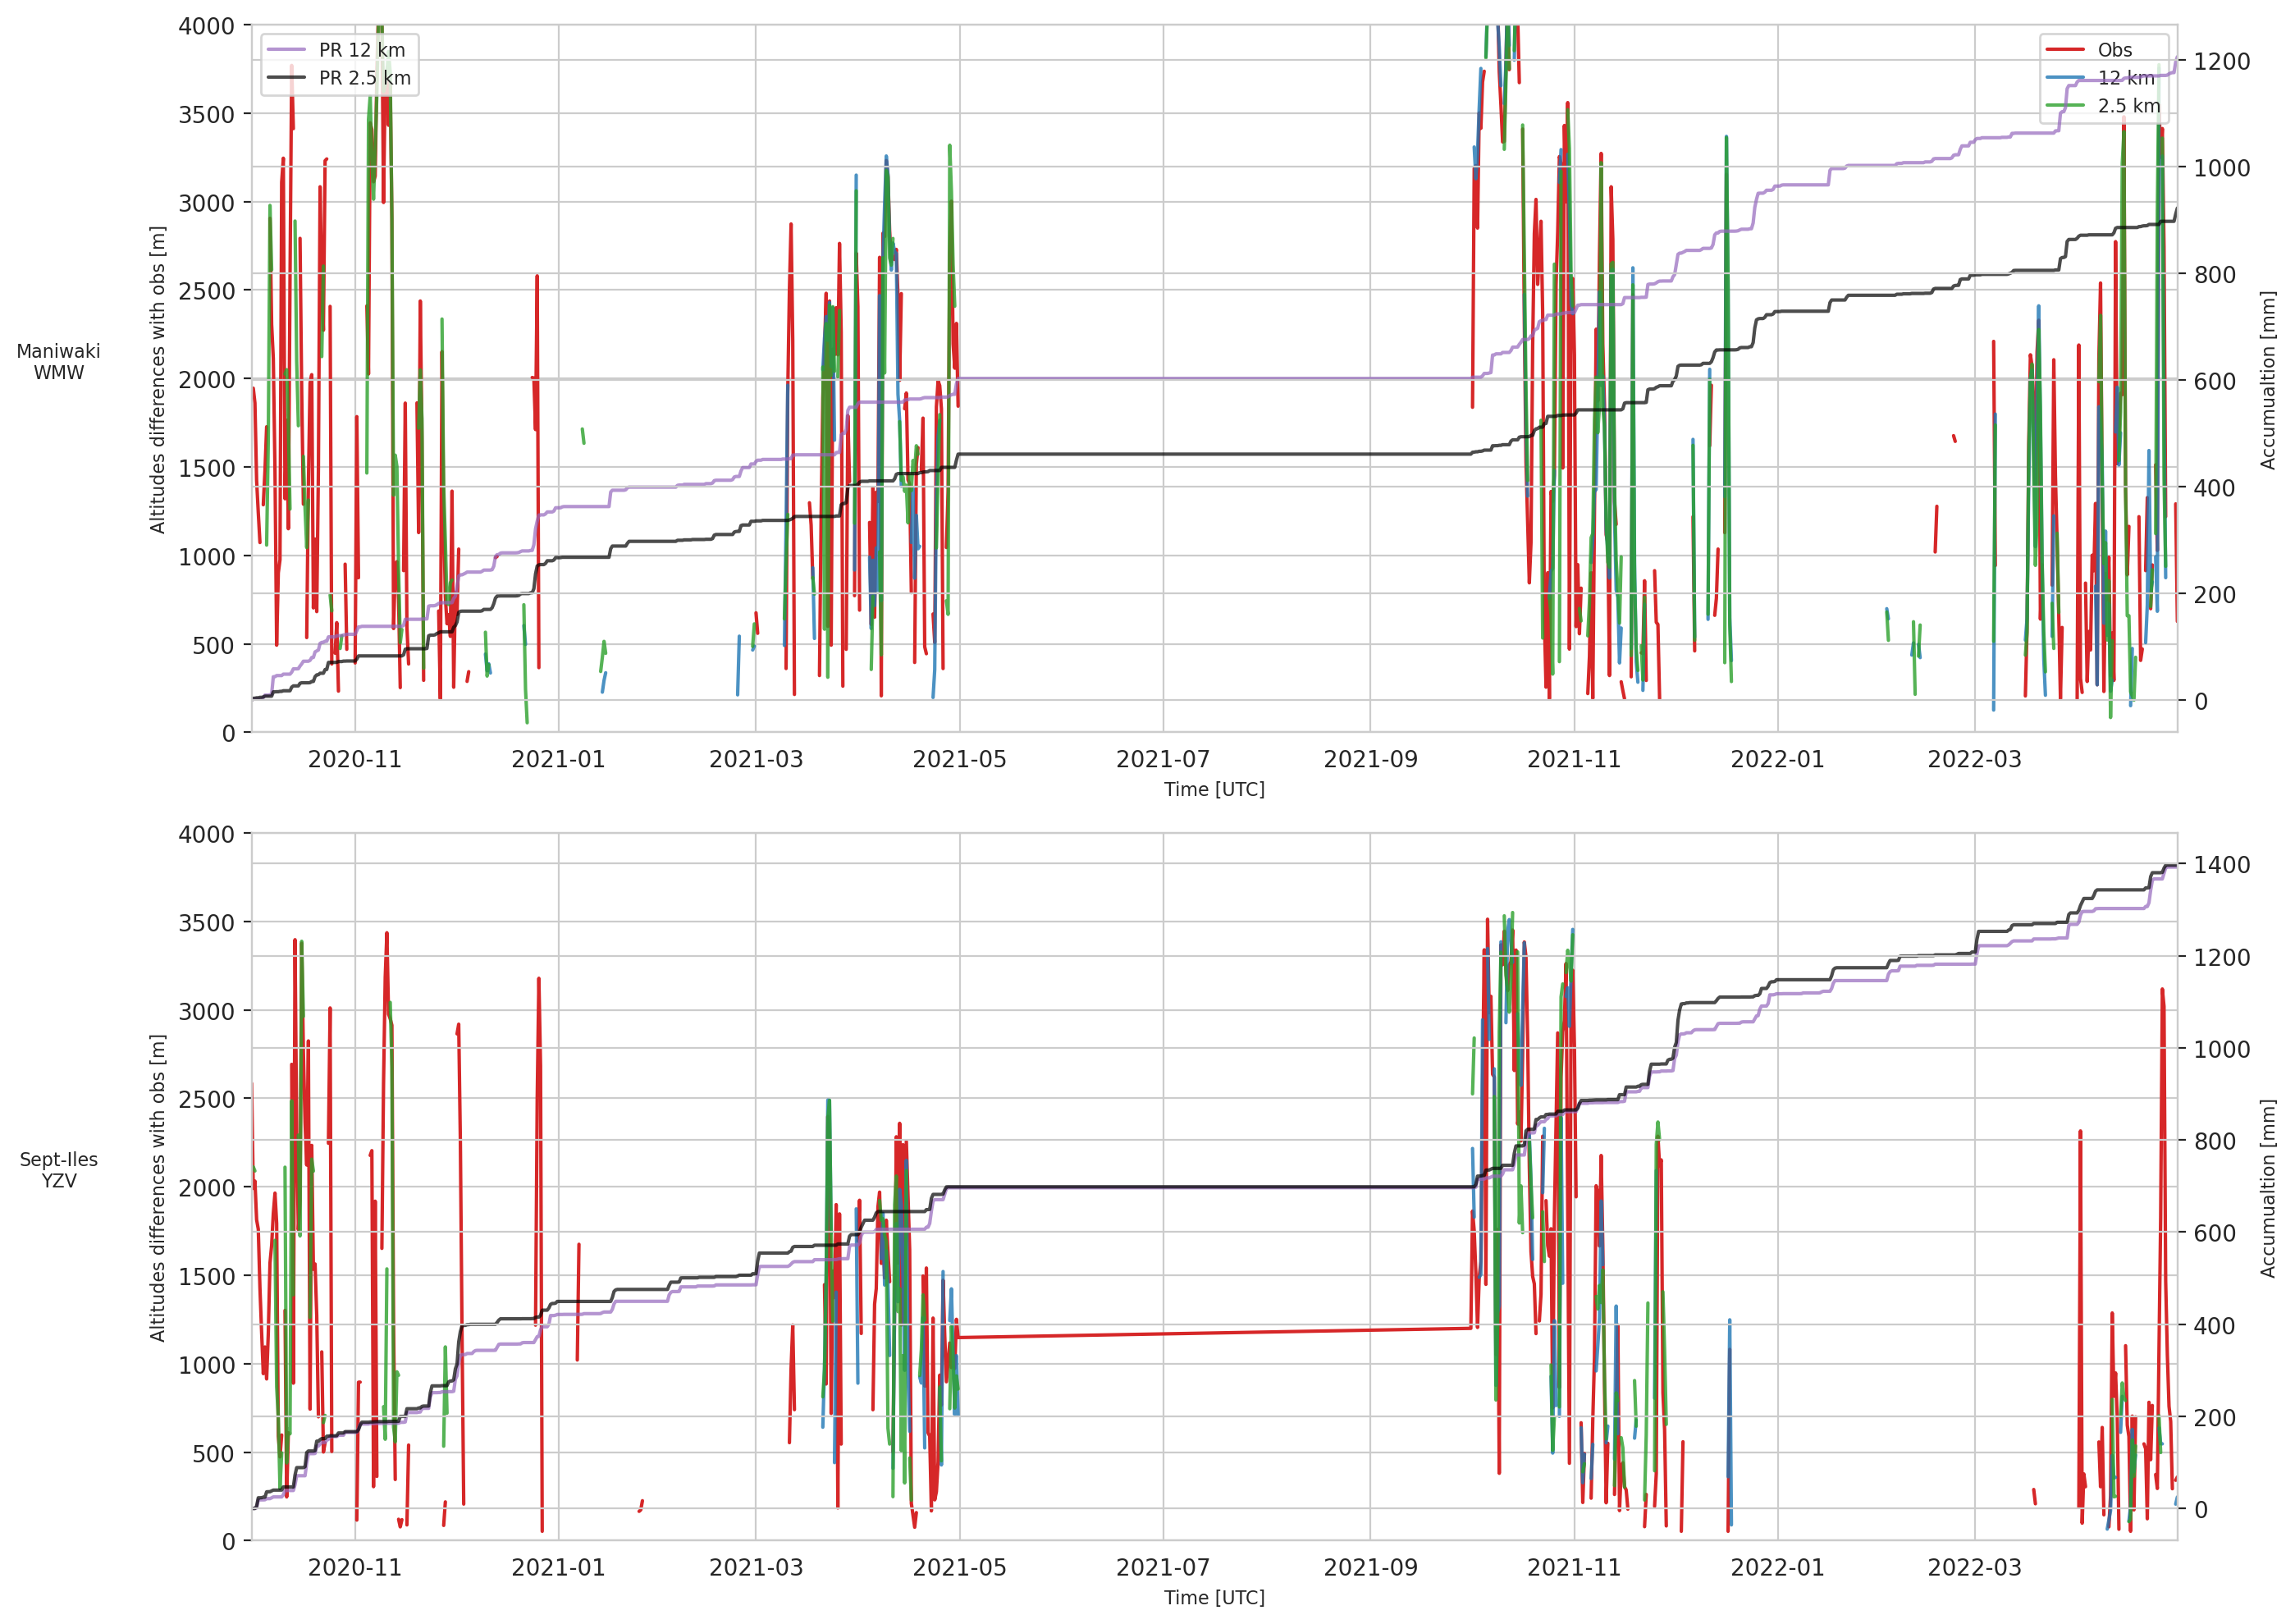

In [26]:

fig = plt.figure(facecolor='white', figsize=(14 , 10 ),dpi=200)

spec = fig.add_gridspec(ncols=1, nrows=2, )
list_axs = []
ax0 = fig.add_subplot(spec[0,0])
ax00 = ax0.twinx()
list_axs.append(ax0)
ax1 = fig.add_subplot(spec[1,0])
ax01 = ax1.twinx()
list_axs.append(ax1)
list_taxs = [ax00,ax01]
for idx_stat,stat in enumerate(name_stat):

    list_taxs[idx_stat].plot(timerange_12h,np.cumsum(list_pr_11km[idx_stat]),label='PR 12 km',color='tab:purple',zorder = -999,alpha = 0.7)
    list_taxs[idx_stat].plot(timerange_12h,np.cumsum(list_pr_2p5km[idx_stat]),label='PR 2.5 km',color='k',zorder = -999,alpha = 0.7)


    mask_pr_11km = np.array(list_pr_11km[idx_stat]) >= 0.2

    mask_pr_2p5km = np.array(list_pr_2p5km[idx_stat]) >= 0.2
    arr_zero_deg_11km = np.ma.masked_array(data=np.array(list_alt_zeros_deg_11km[idx_stat]),mask=mask_pr_11km, fill_value= np.nan)
    arr_zero_deg_2p5km = np.ma.masked_array(data=np.array(list_alt_zeros_deg_2p5km[idx_stat]),mask=mask_pr_2p5km, fill_value= np.nan)
    list_axs[idx_stat].plot(timerange_12h,list_alt_zeros_deg_obs[idx_stat],label='Obs',color='tab:red')
    list_axs[idx_stat].plot(timerange_12h,arr_zero_deg_11km,label='12 km',color='tab:blue',alpha=0.8)
    list_axs[idx_stat].plot(timerange_12h,arr_zero_deg_2p5km,label='2.5 km',color='tab:green',alpha=0.8)


    #list_axs[idx_stat].plot(timerange_12h,arr_zero_deg_11km-np.array(list_alt_zeros_deg_obs[idx_stat]),label='12 km',color='tab:blue',alpha=0.8)
    #list_axs[idx_stat].plot(timerange_12h,arr_zero_deg_2p5km-np.array(list_alt_zeros_deg_obs[idx_stat]),label='2.5 km',color='tab:green',alpha=0.8)



    print('\n',stat)
    print('obs',np.nanmean(np.array(list_alt_zeros_deg_obs[idx_stat])))
    print('obs std',np.nanstd(np.array(list_alt_zeros_deg_obs[idx_stat])))
    print('\n12 km',np.nanmean(arr_zero_deg_11km))
    print('12 km std',np.nanstd(arr_zero_deg_11km))
    print('\n2.5 km',np.nanmean(arr_zero_deg_2p5km))
    print('2.5 km std',np.nanstd(arr_zero_deg_2p5km))
    list_axs[idx_stat].set_ylabel('Altitudes differences with obs [m]', fontsize=8)
    list_axs[idx_stat].set_xlabel('Time [UTC]', fontsize=8)
    list_taxs[idx_stat].set_ylabel('Accumualtion [mm]', fontsize=8)
    #list_axs[idx_stat].set_ylim([-3000,3000])
    list_axs[idx_stat].set_ylim([0,4000])
    list_axs[idx_stat].set_xlim([timerange_12h[0],timerange_12h[-1]])

list_axs[0].legend(loc='upper right', fontsize=8,)
list_taxs[0].legend(loc='upper left', fontsize=8,)
list_axs[0].annotate('Maniwaki\nWMW', xy=(-0.1,.5), xycoords="axes fraction",fontsize = 8,ha='center' )
list_axs[1].annotate('Sept-Iles\nYZV', xy=(-0.1,.5), xycoords="axes fraction",fontsize = 8,ha='center' )
plt.tight_layout()
plt.show()